In [1]:
import os
import sys
import time
import json
from os.path import abspath, dirname
import pandas as pd
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from copy import copy

# current_dir = abspath(dirname(__file__))
current_dir = abspath(dirname(""))
project_path = abspath(dirname(dirname(current_dir)))
sys.path.append(project_path + "/TradeStreamEngine/StreamEngine")

# current_dir = abspath(dirname(__file__))
current_dir = abspath(dirname(""))
project_path = abspath(dirname(dirname(current_dir)))
sys.path.append(project_path + "/TradeStreamEngine/StreamEngineBase")

import synthesis
import spotperp.btc as btcflow
import option.btc as btcoflow

In [4]:
class btcSynth():

    def __init__(self, level_size : int, pranges : np.array, expiry_windows : np.array, 
                 exchanges_spot_perp : list = ["binance", "okx", "bybit", "bitget", "bingx", "kucoin", "deribit", "coinbase", "htx", "gateio"],
                 exchanges_option : list = ["bybit", "okx", "deribit"],
                 book_ceil_thresh : int = 5
                 ):
        """
            level size : 
                Incrimented tier at which trading information, encompassing order books, trades, liquidations, adjustments and open interest occurances are aggregated
                Used for spot and perpetual markets 
                Ex : 20
            pranges : 
                The level size as percerage from the present market price for aggregating options open interest by strike price by expiry window
                Used for options
                Ex : np.array([0.0, 1.0, 2.0, 5.0, 10.0]) will create percentage ranges from 0:1, 1:2 ... -1:0, -2:-1 ...
            expiry_windows : 
                The time horizon size as percerage from the present market price for aggregating options open interest by strike price
                Used for options
                Ex : np.array([0.0, 1.0, 3.0, 7.0]) will create timehorizon ranges from 0:1, 1:3 ... -1:0, -3:-1 ...
            exchanges_spot_perp:
                Selects available exchanges for spot and perpetual instruments
                available : ["binance", "okx", "bybit", "bitget", "bingx", "mexc", "kucoin", "deribit", "coinbase", "htx", "gateio"]
            exchanges_spot_perp:
                Selects available exchanges options
                available : ["bybit", "okx", "deribit"]
            book_ceil_thresh : exclude storing order book data for entries that deviate by a significant percentage from the current market price
            
        """
        self.exchanges_spot_perp = exchanges_spot_perp
        self.exchanges_option = exchanges_option
        self.all_exchange = ["binance", "okx", "bybit", "bitget", "bingx", "mexc", "kucoin", "deribit", "coinbase", "htx", "gateio"]
        self.level_size = level_size
        self.pranges = pranges
        self.expiry_windows = expiry_windows
        self.axis = {
            "binance" : btcflow.binance_flow(level_size, book_ceil_thresh),
            "okx" : btcflow.okx_flow(level_size, book_ceil_thresh),
            "bybit" : btcflow.bybit_flow(level_size, book_ceil_thresh),
            "bingx" : btcflow.bingx_flow(level_size, book_ceil_thresh),
            "mexc" : btcflow.mexc_flow(level_size, book_ceil_thresh),
            "kucoin" : btcflow.kucoin_flow(level_size, book_ceil_thresh),
            "deribit" : btcflow.deribit_flow(level_size, book_ceil_thresh),
            "coinbase" : btcflow.coinbase_flow(level_size, book_ceil_thresh),
            "htx" : btcflow.htx_flow(level_size, book_ceil_thresh),
            "gateio" : btcflow.gateio_flow(level_size, book_ceil_thresh),
            "bitget" : btcflow.bitget_flow(level_size, book_ceil_thresh),
        }
        self.axis = {exchange: value for exchange, value in self.axis.items() if exchange in self.exchanges_spot_perp}

        self.books = {
            "spot" : synthesis.booksmerger("btc", "spot", axis = {
                "_".join([exchange, flow]) : self.axis[exchange].spot_axis["books"][flow] for exchange in self.axis.keys() for flow in self.axis[exchange].spot_axis["books"].keys()
            }
                                           ),
            "perpetual" : synthesis.booksmerger("btc", "perpetul", axis = {
                "_".join([exchange, flow]) : self.axis[exchange].perpetual_axis["books"][flow] for exchange in self.axis.keys() for flow in self.axis[exchange].perpetual_axis["books"].keys()
            }
                                           ),
        }
        self.trades = {
            "spot" : synthesis.tradesmerger("btc", "spot", axis = {
                "_".join([exchange, flow]) : self.axis[exchange].spot_axis["trades"][flow] for exchange in self.axis.keys() if exchange != "deribit" for flow in self.axis[exchange].spot_axis["trades"].keys()
            }
                                           ),
            "perpetual" : synthesis.tradesmerger("btc", "perpetul", axis = {
                "_".join([exchange, flow]) : self.axis[exchange].perpetual_axis["trades"][flow] for exchange in self.axis.keys() if exchange != "coinbase" for flow in self.axis[exchange].perpetual_axis["trades"].keys() 
            }
                                           ),
        }

        self.adjustmests = {
            "spot" : synthesis.booksadjustments("btc", "spot", self.books["spot"], self.trades["spot"]),
            "perpetual" : synthesis.booksadjustments("btc", "perpetual", self.books["perpetual"], self.trades["perpetual"])
        }

        self.oifunding =  synthesis.oiomnifier("btc", "perpetul", axis = {
                "_".join([exchange, flow]) : self.axis[exchange].perpetual_axis["oifunding"][flow] for exchange in self.axis.keys() if exchange != "coinbase" for flow in self.axis[exchange].perpetual_axis["oifunding"].keys() 
            }
                                           )

        self.liquidations =  synthesis.lomnifier("btc", "perpetul", axis = {
                "_".join([exchange, flow]) : self.axis[exchange].perpetual_axis["liquidations"][flow] for exchange in self.axis.keys() if exchange in ["binance", "okx", "bybit", "gateio"] for flow in self.axis[exchange].perpetual_axis["liquidations"].keys() 
            }
                                           )

        self.positionsTTA =  synthesis.indomnifier("btc", "perpetul", "TTA",  {
                "_".join([exchange, flow]) : self.axis[exchange].perpetual_axis["indicators"][flow] for exchange in self.axis.keys() if exchange in ["binance"] for flow in self.axis[exchange].perpetual_axis["indicators"].keys() if "TTA" in flow 
            },
            self.oifunding
                                           )

        self.positionsTTP =  synthesis.indomnifier("btc", "perpetul", "TTP", {
                "_".join([exchange, flow]) : self.axis[exchange].perpetual_axis["indicators"][flow] for exchange in self.axis.keys() if exchange in ["binance"] for flow in self.axis[exchange].perpetual_axis["indicators"].keys() if "TTP" in flow
            },
            self.oifunding
                                           )

        self.positionsGTA =  synthesis.indomnifier("btc", "perpetul", "GTA", {
                "_".join([exchange, flow]) : self.axis[exchange].perpetual_axis["indicators"][flow] for exchange in self.axis.keys() if exchange in ["binance", "okx", "bybit"] for flow in self.axis[exchange].perpetual_axis["indicators"].keys() if "GTA" in flow
            },
            self.oifunding
                                           )

        # options
        self.optionoi = btcoflow.btc(pranges, expiry_windows, exchanges_option)
        self.optionoi.axis = {exchange: value for exchange, value in self.optionoi.axis.items() if exchange in self.exchanges_option}
        

        self.data = dict()


    def merge(self):
        for insType in self.books.keys():
            self.books[insType].merge_snapshots()
            self.data["_".join(["books", insType])] = self.books[insType].snapshotO

        for insType in self.trades.keys():
            self.trades[insType].merge_snapshots()
            self.data["_".join(["trades", insType])] = self.trades[insType].snapshotO

        for insType in self.adjustmests.keys():
            self.adjustmests[insType].get_adjusted_orders()
            self.data["_".join(["adjustmests", insType])] = self.adjustmests[insType].data

        self.oifunding.merge_snapshots()
        self.data["_".join(["oifunding", "perpetual"])] = self.oifunding.snapshot

        self.liquidations.merge_snapshots()
        self.data["_".join(["liquidations", "perpetual"])] = self.liquidations.snapshot

        self.positionsTTA.merge_ratios()
        self.data["_".join(["TTA", "perpetual"])] = self.positionsTTA.data

        self.positionsTTP.merge_ratios()
        self.data["_".join(["TTP", "perpetual"])] = self.positionsTTP.data

        self.positionsGTA.merge_ratios()
        self.data["_".join(["GTA", "perpetual"])] = self.positionsGTA.data

        self.optionoi.merge()
        self.data["_".join(["oi", "option"])] = self.optionoi.data
        
    # Merge
    def ratrive_data(self, data=None, type_=None):
        """
            books_spot, books_perp, trades_spot, trades_perp, oifunding, liquidations, TTA, TTP, GTA
        """
        if data == None and type_ == None:
            return self.data
    
    # add data

    # Spot books

    def add_binance_spot_btcusdt_depth(self, data):
        self.books["spot"].axis["binance_btcusdt"].update_books(data)

    def add_binance_spot_btcfdusd_depth(self, data):
        self.books["spot"].axis["binance_btcfdusd"].update_books(data)

    def add_okx_spot_btcusdt_depth(self, data):
        self.books["spot"].axis["okx_btcusdt"].update_books(data)

    def add_bybit_spot_btcusdt_depth(self, data):
        self.books["spot"].axis["bybit_btcusdt"].update_books(data)

    def add_bybit_spot_btcusdt_depth(self, data):
        self.books["spot"].axis["bybit_btcusdt"].update_books(data)

    def add_bybit_spot_btcusdc_depth(self, data):
        self.books["spot"].axis["bybit_btcusdc"].update_books(data)

    def add_bingx_spot_btcusdt_depth(self, data):
        self.books["spot"].axis["bingx_btcusdt"].update_books(data)

    def add_mexc_spot_btcusdt_depth(self, data):
        self.books["spot"].axis["mexc_btcusdt"].update_books(data)

    def add_kucoin_spot_btcusdt_depth(self, data):
        self.books["spot"].axis["kucoin_btcusdt"].update_books(data)

    def add_coinbase_spot_btcusd_depth(self, data):
        self.books["spot"].axis["coinbase_btcusd"].update_books(data)

    def add_htx_spot_btcusdt_depth(self, data):
        self.books["spot"].axis["htx_btcusdt"].update_books(data)

    def add_gateio_spot_btcusdt_depth(self, data):
        self.books["spot"].axis["gateio_btcusdt"].update_books(data)

    def add_bitget_spot_btcusdt_depth(self, data):
        self.books["spot"].axis["bitget_btcusdt"].update_books(data)

    # Spot trades

    def add_binance_spot_btcusdt_trades(self, data):
        self.trades["spot"].axis["binance_btcusdt"].input_trades(data)

    def add_binance_spot_btcfdusd_trades(self, data):
        self.trades["spot"].axis["binance_btcfdusd"].input_trades(data)

    def add_okx_spot_btcusdt_trades(self, data):
        self.trades["spot"].axis["okx_btcusdt"].input_trades(data)

    def add_bybit_spot_btcusdt_trades(self, data):
        self.trades["spot"].axis["bybit_btcusdt"].input_trades(data)

    def add_bybit_spot_btcusdt_trades(self, data):
        self.trades["spot"].axis["bybit_btcusdt"].input_trades(data)

    def add_bybit_spot_btcusdc_trades(self, data):
        self.trades["spot"].axis["bybit_btcusdc"].input_trades(data)

    def add_bingx_spot_btcusdt_trades(self, data):
        self.trades["spot"].axis["bingx_btcusdt"].input_trades(data)

    def add_mexc_spot_btcusdt_trades(self, data):
        self.trades["spot"].axis["mexc_btcusdt"].input_trades(data)

    def add_kucoin_spot_btcusdt_trades(self, data):
        self.trades["spot"].axis["kucoin_btcusdt"].input_trades(data)

    def add_coinbase_spot_btcusd_trades(self, data):
        self.trades["spot"].axis["coinbase_btcusd"].input_trades(data)

    def add_htx_spot_btcusdt_trades(self, data):
        self.trades["spot"].axis["htx_btcusdt"].input_trades(data)

    def add_gateio_spot_btcusdt_trades(self, data):
        self.trades["spot"].axis["gateio_btcusdt"].input_trades(data)

    def add_bitget_spot_btcusdt_trades(self, data):
        self.trades["spot"].axis["bitget_btcusdt"].input_trades(data)

    # Perp books
    
    def add_binance_perp_btcusdt_depth(self, data):
        self.books["perpetual"].axis["binance_btcusdt"].update_books(data) 

    def add_binance_perp_btcusd_depth(self, data):
        self.books["perpetual"].axis["binance_btcusd"].update_books(data) 

    def add_okx_perp_btcusdt_depth(self, data):
        self.books["perpetual"].axis["okx_btcusdt"].update_books(data) 

    def add_okx_perp_btcusd_depth(self, data):
        self.books["perpetual"].axis["okx_btcusd"].update_books(data)

    def add_bybit_perp_btcusdt_depth(self, data):
        self.books["perpetual"].axis["bybit_btcusdt"].update_books(data) 

    def add_bybit_perp_btcusd_depth(self, data):
        self.books["perpetual"].axis["bybit_btcusd"].update_books(data)

    def add_bingx_perp_btcusdt_depth(self, data):
        self.books["perpetual"].axis["bingx_btcusdt"].update_books(data)   

    def add_mexc_perp_btcusdt_depth(self, data):
        self.books["perpetual"].axis["mexc_btcusdt"].update_books(data) 

    def add_kucoin_perp_btcusdt_depth(self, data):
        self.books["perpetual"].axis["kucoin_btcusdt"].update_books(data) 

    def add_deribit_perp_btcusd_depth(self, data):
        self.books["perpetual"].axis["deribit_btcusd"].update_books(data) 

    def add_htx_perp_btcusdt_depth(self, data):
        self.books["perpetual"].axis["htx_btcusdt"].update_books(data) 

    def add_gateio_perp_btcusdt_depth(self, data):
        self.books["perpetual"].axis["gateio_btcusdt"].update_books(data) 

    def add_bitget_perp_btcusdt_depth(self, data):
        self.books["perpetual"].axis["bitget_btcusdt"].update_books(data) 

    # Perp trades

    def add_binance_perp_btcusdt_trades(self, data):
        self.trades["perpetual"].axis["binance_btcusdt"].input_trades(data) 

    def add_binance_perp_btcusd_trades(self, data):
        self.trades["perpetual"].axis["binance_btcusd"].input_trades(data) 

    def add_okx_perp_btcusdt_trades(self, data):
        self.trades["perpetual"].axis["okx_btcusdt"].input_trades(data) 

    def add_okx_perp_btcusd_trades(self, data):
        self.trades["perpetual"].axis["okx_btcusd"].input_trades(data)

    def add_bybit_perp_btcusdt_trades(self, data):
        self.trades["perpetual"].axis["bybit_btcusdt"].input_trades(data) 

    def add_bybit_perp_btcusd_trades(self, data):
        self.trades["perpetual"].axis["bybit_btcusd"].input_trades(data)

    def add_bingx_perp_btcusdt_trades(self, data):
        self.trades["perpetual"].axis["bingx_btcusdt"].input_trades(data)   

    def add_mexc_perp_btcusdt_trades(self, data):
        self.trades["perpetual"].axis["mexc_btcusdt"].input_trades(data) 

    def add_kucoin_perp_btcusdt_trades(self, data):
        self.trades["perpetual"].axis["kucoin_btcusdt"].input_trades(data) 

    def add_deribit_perp_btcusd_trades(self, data):
        self.trades["perpetual"].axis["deribit_btcusd"].input_trades(data) 

    def add_htx_perp_btcusdt_trades(self, data):
        self.trades["perpetual"].axis["htx_btcusdt"].input_trades(data) 

    def add_gateio_perp_btcusdt_trades(self, data):
        self.trades["perpetual"].axis["gateio_btcusdt"].input_trades(data) 

    def add_bitget_perp_btcusdt_trades(self, data):
        self.trades["perpetual"].axis["bitget_btcusdt"].input_trades(data)         

    # OI

    def add_binance_perp_btcusdt_oi(self, data):
        self.oifunding.axis["binance_btcusdt"].input_oi(data) 

    def add_binance_perp_btcusd_oi(self, data):
        self.oifunding.axis["binance_btcusd"].input_oi(data) 

    def add_okx_perp_btcusdt_oi(self, data):
        self.oifunding.axis["okx_btcusdt"].input_oi(data) 

    def add_okx_perp_btcusd_oi(self, data):
        self.oifunding.axis["okx_btcusd"].input_oi(data) 

    def add_bingx_perp_btcusdt_oi(self, data):
        self.oifunding.axis["bingx_btcusdt"].input_oi(data) 

    def add_gateio_perp_btcusdt_oi(self, data):
        self.oifunding.axis["gateio_btcusdt"].input_oi(data) 

    def add_htx_perp_btcusdt_oi(self, data):
        self.oifunding.axis["htx_btcusdt"].input_oi(data) 
    
    # Funding

    def add_binance_perp_btcusdt_funding(self, data):
        self.oifunding.axis["binance_btcusdt"].input_funding(data) 

    def add_binance_perp_btcusd_funding(self, data):
        self.oifunding.axis["binance_btcusd"].input_funding(data) 

    def add_okx_perp_btcusdt_funding(self, data):
        self.oifunding.axis["okx_btcusdt"].input_funding(data) 

    def add_okx_perp_btcusd_funding(self, data):
        self.oifunding.axis["okx_btcusd"].input_funding(data) 

    def add_bingx_perp_btcusdt_funding(self, data):
        self.oifunding.axis["bingx_btcusdt"].input_funding(data) 

    def add_gateio_perp_btcusdt_funding(self, data):
        self.oifunding.axis["gateio_btcusdt"].input_funding(data) 

    def add_htx_perp_btcusdt_funding(self, data):
        self.oifunding.axis["htx_btcusdt"].input_funding(data) 
    
    # OIFund  

    def add_bybit_perp_btcusdt_oifunding(self, data):
        self.oifunding.axis["bybit_btcusdt"].input_oi_funding(data) 

    def add_bybit_perp_btcusd_oifunding(self, data):
        self.oifunding.axis["bybit_btcusd"].input_oi_funding(data) 

    def add_mexc_perp_btcusdt_oifunding(self, data):
        self.oifunding.axis["mexc_btcusdt"].input_oi_funding(data) 

    def add_kucoin_perp_btcusdt_oifunding(self, data):
        self.oifunding.axis["kucoin_btcusdt"].input_oi_funding(data) 

    def add_bitget_perp_btcusdt_oifunding(self, data):
        self.oifunding.axis["bitget_btcusdt"].input_oi_funding(data) 

    def add_htx_perp_btcusdt_funding(self, data):
        self.oifunding.axis["htx_btcusdt"].input_oi_funding(data) 

    def add_deribit_perp_btcusd_oifunding(self, data):
        self.oifunding.axis["deribit_btcusd"].input_oi_funding(data) 
    
    # Liquidations
    
    def add_binance_perp_btcusdt_liquidations(self, data):
        self.liquidations.axis["binance_btcusdt"].input_liquidations(data) 

    def add_binance_perp_btcusd_liquidations(self, data):
        self.liquidations.axis["binance_btcusd"].input_liquidations(data) 

    def add_okx_perp_btc_liquidations(self, data):
        self.liquidations.axis["okx_btc"].input_liquidations(data) 

    def add_bybit_perp_btcusdt_liquidations(self, data):
        self.liquidations.axis["bybit_btcusdt"].input_liquidations(data) 

    def add_bybit_perp_btcusd_liquidations(self, data):
        self.liquidations.axis["bybit_btcusd"].input_liquidations(data)

    def add_gateio_perp_btcusdt_liquidations(self, data):
        self.liquidations.axis["gateio_btcusdt"].input_liquidations(data)  
    
    # Positions

    def add_binance_perp_btcusdt_tta(self, data):
        self.positionsTTA.axis_ratio["binance_btcusdt_TTA"].input_binance_gta_tta_ttp(data) 

    def add_binance_perp_btcusd_tta(self, data):
        self.positionsTTA.axis_ratio["binance_btcusd_TTA"].input_binance_gta_tta_ttp(data) 

    def add_binance_perp_btcusdt_ttp(self, data):
        self.positionsTTP.axis_ratio["binance_btcusdt_TTP"].input_binance_gta_tta_ttp(data) 

    def add_binance_perp_btcusd_ttp(self, data):
        self.positionsTTP.axis_ratio["binance_btcusd_TTP"].input_binance_gta_tta_ttp(data) 

    def add_binance_perp_btcusdt_gta(self, data):
        self.positionsGTA.axis_ratio["binance_btcusdt_GTA"].input_binance_gta_tta_ttp(data) 

    def add_binance_perp_btcusd_gta(self, data):
        self.positionsGTA.axis_ratio["binance_btcusd_GTA"].input_binance_gta_tta_ttp(data) 

    def add_okx_perp_btc_gta(self, data):
        self.positionsGTA.axis_ratio["okx_btc_GTA"].input_okx_gta(data) 

    def add_bybit_perp_btcusdt_gta(self, data):
        self.positionsGTA.axis_ratio["bybit_btcusdt_GTA"].input_bybit_gta(data) 

    def add_bybit_perp_btcusd_gta(self, data):
        self.positionsGTA.axis_ratio["bybit_btcusd_GTA"].input_bybit_gta(data)

    # Options

    def add_deribit_option_btc_oi(self, data):
        self.optionoi.aggregator.axis["deribit"].input_oi(data)

    def add_bybit_option_btc_oi(self, data):
        self.optionoi.aggregator.axis["bybit"].input_oi(data)

    def add_okx_option_btc_oi(self, data):
        self.optionoi.aggregator.axis["okx"].input_oi(data)

    # Test Synth

    def input_from_json(self):
        """
            child directory data should contain json files. if the methods is add_bybit_perp_btcusd_gta, then the file should be names bybit_perp_btcusd_gta.json
        """
        callable_methods = [method for method in dir(self) if callable(getattr(self, method)) and not method.startswith("__")]
        methods = []
        methods_str = []
        for method_name in callable_methods:
            if method_name.split("_")[0] in self.exchanges_spot_perp and method_name.split("_")[2] != "option":
                method = getattr(self, method_name)
                methods.append(method)
                methods_str.append(method_name)
            if method_name.split("_")[0] in self.exchanges_option and method_name.split("_")[2] not in ["spot", "perp"]:
                method = getattr(self, method_name)
                methods.append(method)
                methods_str.append(method_name)      
        import os
        parent_dir = os.getcwd()
        data_dir  = parent_dir + '/data'
        files = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]
        methods_str = ["_".join(x.split("_")[1:]) + ".json" for x in sorted(methods_str)]
        files = [x for x in sorted(files) if x not in ["news.json"]]

        v = {
            x : { 
            "data" : json.load(open("".join(["data/", x]))),
            "lookup" : f,
            } 
            for x, f in zip(files, methods)
            }

        for key in v.keys():
            for d in v[key]["data"]:
                d = json.dumps(d)
                v[key]["lookup"](d)

    def test_empty_dataframes(self):

        total_empty = []

        # spot

        for books, trades in zip(self.books["spot"].axis, self.trades["spot"].axis):
            b = self.books["spot"].axis[books].snapshot
            t = self.trades["spot"].axis[trades].snapshot_total
            try:
                if b.empty:
                    print(f"spot, books, {books}, is empty")
                    total_empty.append(b)
            except:
                print(f"spot, books, {books}, is empty")
                total_empty.append(b)
            try:
                if t.empty:
                    print(f"spot, trades, {trades}, is empty")
                    total_empty.append(b)
            except:
                print(f"spot, trades, {trades}, is empty")
                total_empty.append(b)
        
        # perp

        for books, trades in zip(self.books["perpetual"].axis, self.trades["perpetual"].axis):
            b = self.books["perpetual"].axis[books].snapshot
            t = self.trades["perpetual"].axis[trades].snapshot_total
            try:
                if b.empty:
                    print(f"perpetual, books, {books}, is empty")
                    total_empty.append(b)
            except:
                print(f"perpetual, books, {books}, is empty")
                total_empty.append(b)
            try:
                if t.empty:
                    print(f"perpetual, trades, {trades}, is empty")
                    total_empty.append(b)
            except:
                print(f"perpetual, trades, {trades}, is empty")
                total_empty.append(b)

        # oif

        for oiff in self.oifunding.axis:
            oif = self.oifunding.axis[oiff].snapshot
            try:
                if len(oif) != 0:
                    pass
                else:
                    print(f"perpetual, oif, {oiff}, is empty")
                    total_empty.append(p)
            except:
                print(f"perpetual, oif, {oiff}, is empty")
                total_empty.append(b)


        # Liquidations

        for liqss in self.liquidations.axis:
            liqs = self.liquidations.axis[liqss].snapshot_total
            try:
                if liqs.empty:
                    print(f"perpetual, liquidations, {liqss}, is empty")
                    total_empty.append(b)
            except:
                print(f"perpetual, liquidations, {liqss}, is empty")
                total_empty.append(b)

        # Positions
        
        for TTA in self.positionsTTA.axis_ratio:
            r = self.positionsTTA.axis_ratio[TTA].data
            if len(r) != 0:
                pass
            else:
                print(f"perpetual, TTA, {TTA}, is empty")
                total_empty.append(TTA)
        
        for TTP in self.positionsTTP.axis_ratio:
            r = self.positionsTTP.axis_ratio[TTP].data
            if len(r) != 0:
                pass
            else:
                print(f"perpetual, TTP, {TTP}, is empty")
                total_empty.append(TTP)

        for GTA in self.positionsGTA.axis_ratio:
            r = self.positionsGTA.axis_ratio[GTA].data
            if len(r) != 0:
                pass
            else:
                print(f"perpetual, GTA, {GTA}, is empty")
                total_empty.append(GTA)

        if len(total_empty) == 0:
            print("No empty frames")
        
        # return total_empty
    
    def test_display_books(self, insType, exinstrument):
        """
            insType : spot. perpetual
            exinstrument : Ex. gateio_btcusdt
        """
        return self.books[insType].axis[exinstrument].df

    def test_display_trades(self, insType, exinstrument):
        """
            insType : spot. perpetual
            exinstrument : Ex. gateio_btcusdt
        """
        print(self.trades[insType].axis[exinstrument].buys)
        if self.trades[insType].axis[exinstrument].buys.empty:
            print(self.trades[insType].axis[exinstrument].sells)

    def test_display_oif(self, exinstrument):
        """
            exinstrument : Ex. gateio_btcusdt
        """
        print(self.oifunding.axis[exinstrument].raw_data)

    def test_display_liquidations(self, exinstrument):
        """
            exinstrument : Ex. gateio_btcusdt
        """
        print(self.liquidations.axis[exinstrument].longs)
        if self.liquidations.axis[exinstrument].longs.empty:
            print(self.liquidations.axis[exinstrument].shorts)

    def test_display_gta(self, exinstrument):
        """
            exinstrument : Ex. binance_btcusdt
        """
        print("Ratios : ", self.positionsGTA.axis_ratio[exinstrument].data)

    def test_display_tta(self, exinstrument):
        """
            exinstrument : Ex. binance_btcusdt
        """
        print("Ratios : ", self.positionsTTA.axis_ratio[exinstrument].data)
    def test_display_ttp(self, exinstrument):
        """
            exinstrument : Ex. binance_btcusdt
        """
        print("Ratios : ", self.positionsTTP.axis_ratio[exinstrument].data)
    
    def test_display_data(self, what):
        """
            what : 'books_spot', 'books_perpetual', 'trades_spot', 'trades_perpetual', 'adjustmests_spot', 'adjustmests_perpetual', 'oifunding_perpetual', 'liquidations_perpetual', 'TTA_perpetual', 'TTP_perpetual', 'GTA_perpetual', 'oi_option'
            IF the distribution has tails, you had miscalculations .
        """
        data = self.data.get(what)
        df = pd.DataFrame(list(data.items()), columns=['Category', 'Value'])
        df.plot(kind='bar', x='Category', y='Value', legend=False)
        plt.title('Distribution Plot')
        plt.xlabel('Category')
        plt.ylabel('Value')
        plt.show()
        

# From provided data files some had less than 60 seconds of data
        
# spot, trades, bingx_btcusdt, is empty                  # ok
# spot, books, mexc_btcusdt, is empty                    # ok
# spot, books, kucoin_btcusdt, is empty                  # ok
# spot, books, htx_btcusdt, is empty                    # ok
# spot, trades, htx_btcusdt, is empty                     # ok
# spot, books, bitget_btcusdt, is empty                   # ok
# perpetual, trades, bybit_btcusd, is empty               # ok
# perpetual, books, mexc_btcusdt, is empty                # ok
# perpetual, trades, mexc_btcusdt, is empty               # ok
# perpetual, books, kucoin_btcusdt, is empty              # ok
# perpetual, books, htx_btcusdt, is empty                 # ok    
# perpetual, trades, htx_btcusdt, is empty                # ok
# perpetual, books, gateio_btcusdt, is empty              # ok
# perpetual, trades, gateio_btcusdt, is empty             # ok  
# perpetual, oif, gateio_btcusdt, is empty                # ok
# perpetual, oif, bitget_btcusdt, is empty                # ok
# perpetual, liquidations, binance_btcusdt, is empty      # ok
# perpetual, liquidations, binance_btcusd, is empty       # ok
# perpetual, liquidations, okx_btc, is empty              # ok
# perpetual, liquidations, bybit_btcusdt, is empty        # ok
# perpetual, liquidations, bybit_btcusd, is empty         # ok
# perpetual, liquidations, gateio_btcusdt, is empty       # ok

In [5]:
import warnings
warnings.filterwarnings("ignore")
a = btcSynth(20, np.array([0.0, 1.0, 2.0, 5.0, 10.0]) , np.array([0.0, 1.0, 2.0, 5.0, 10.0]))
a.input_from_json()

{'binance': <spotperp.btc.binance_flow object at 0x000001F99ACB7160>, 'okx': <spotperp.btc.okx_flow object at 0x000001F99ADA9D50>, 'bybit': <spotperp.btc.bybit_flow object at 0x000001F99ADAA4A0>, 'bingx': <spotperp.btc.bingx_flow object at 0x000001F99ADBE3B0>, 'kucoin': <spotperp.btc.kucoin_flow object at 0x000001F99ADBFFD0>, 'deribit': <spotperp.btc.deribit_flow object at 0x000001F99AD68190>, 'coinbase': <spotperp.btc.coinbase_flow object at 0x000001F99AD69F30>, 'htx': <spotperp.btc.htx_flow object at 0x000001F99AD69CC0>, 'gateio': <spotperp.btc.gateio_flow object at 0x000001F99AD6A2F0>, 'bitget': <spotperp.btc.bitget_flow object at 0x000001F99AD845B0>}


In [4]:
a.merge()

In [5]:
a.data.keys()

dict_keys(['books_spot', 'books_perpetual', 'trades_spot', 'trades_perpetual', 'adjustmests_spot', 'adjustmests_perpetual', 'oifunding_perpetual', 'liquidations_perpetual', 'TTA_perpetual', 'TTP_perpetual', 'GTA_perpetual', 'oi_option'])

In [6]:
# a.data.get("books_perpetual")

In [7]:
a.data.get("trades_spot")

{'timestamp': '2024-03-09 21:48',
 'buyVolume': 3.4980084300000005,
 'sellVolume': 2.8372953699999997,
 'open': 43427.0,
 'close': 43380.27,
 'low': 43380.27,
 'high': 43427.0,
 'volatility': 16.414414234479246,
 'volumeProfile': {'43380.0': 0.8839473499999999,
  '43400.0': 1.56103355,
  '43420.0': 0.02136707,
  '43440.0': 2.86654283,
  '61740.0': 0.00644,
  '61840.0': 0.821977,
  '61860.0': 0.046101,
  '61920.0': 0.127895},
 'buyVolumeProfile': {'43380.0': 0.23540132000000002,
  '43400.0': 0.86013202,
  '43420.0': 0.02103026,
  '43440.0': 2.1830028300000004,
  '61740.0': 0.00638,
  '61840.0': 0.147842,
  '61860.0': 0.015539,
  '61920.0': 0.028680999999999998},
 'sellVolumeProfile': {'43380.0': 0.6485460300000001,
  '43400.0': 0.7009015300000001,
  '43420.0': 0.00033681,
  '43440.0': 0.6835399999999999,
  '61740.0': 6.000000000000001e-05,
  '61840.0': 0.6741349999999999,
  '61860.0': 0.030562,
  '61920.0': 0.099214},
 'numberBuyTrades': 146,
 'numberSellTrades': 124,
 'buyTrades': [0.0

In [8]:
data = a.data.get("trades_perpetual").get("volumeProfile")
filtered_dict = {key: value for key, value in data.items() if value > 10000}

filtered_dict

{}

In [9]:
# Filter perpetual books

In [5]:
b = a.test_display_books("perpetual", "kucoin_btcusdt")

list_perp_instruments =["kucoin_btcusdt", "bybit_btcusdt", "bybit_btcusd", "binance_btcusd",
                        "binance_btcusdt", "bingx_btcusdt", "mexc_btcusdt", 
                        "okx_btcusdt", "okx_btcusd", "bitget_btcusdt", "htx_btcusdt", 
                        "gateio_btcusdt", "deribit_btcusd",
                        ]

list_spot_instruments =["kucoin_btcusdt", "bybit_btcusdt", "bybit_btcusdc", "binance_btcusdt",
                        "binance_btcfdusd", "bingx_btcusdt", "mexc_btcusdt", 
                        "okx_btcusdt", "bitget_btcusdt", "htx_btcusdt", 
                        "gateio_btcusdt", "coinbase_btcusd",
                        ]

In [6]:
# MEXC is trash. Deal with it!

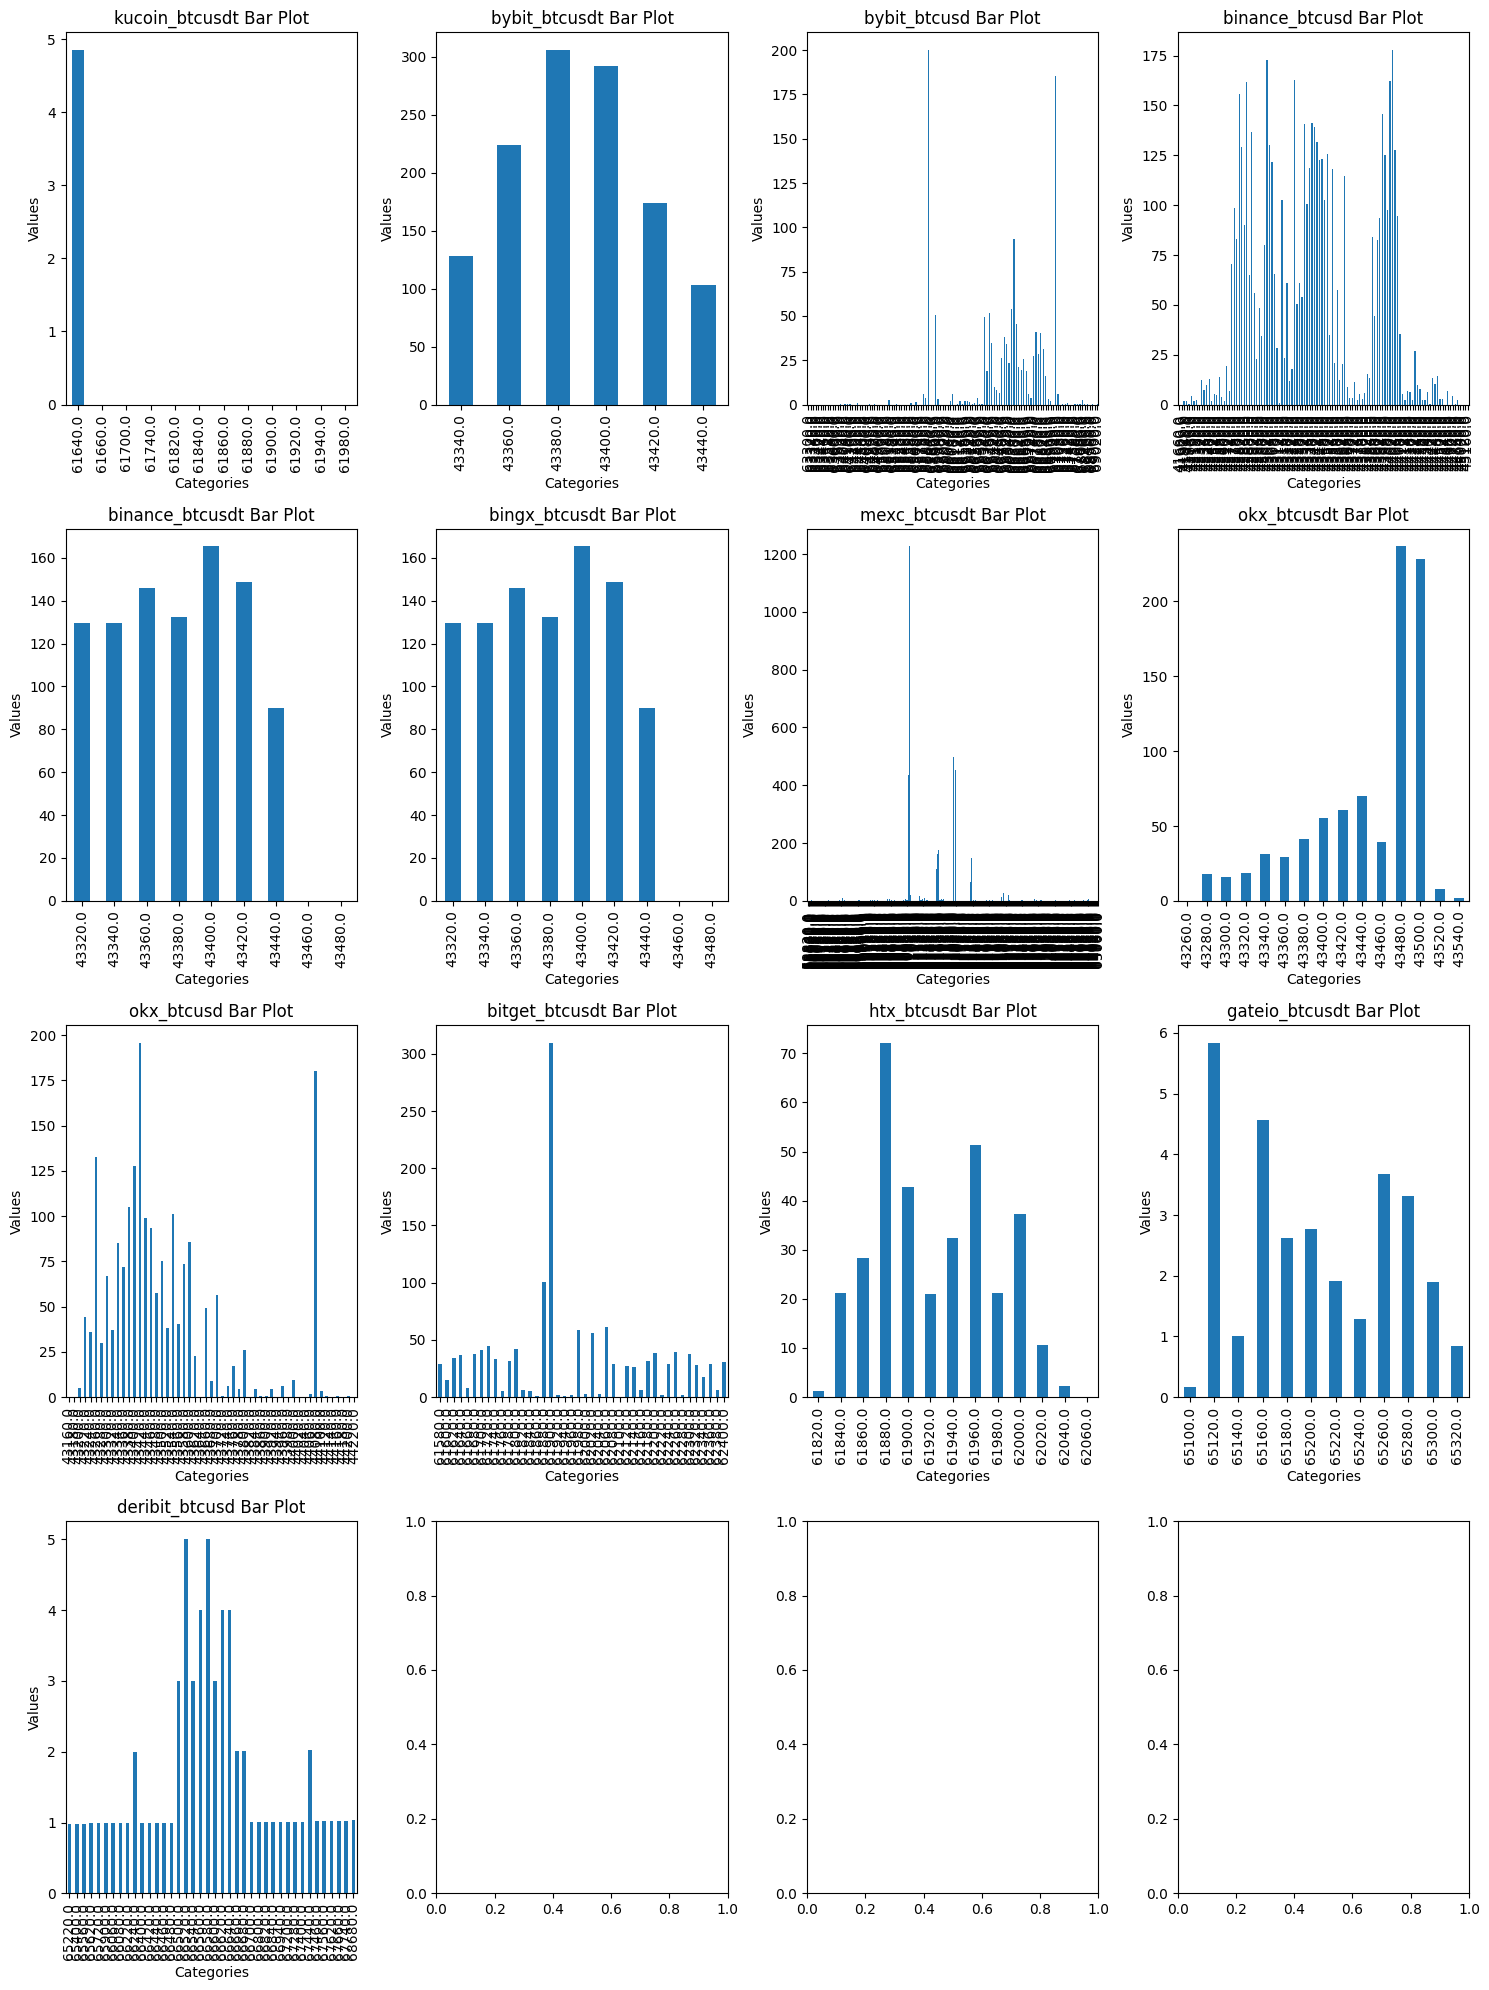

<Figure size 640x480 with 0 Axes>

In [7]:
def plot_perp_books():
    graphs = {}
    for exinstrument in list_perp_instruments:
        b = a.books["perpetual"].axis[exinstrument].df
        # Iterate through rows
        for index, row in b.iterrows():
            if not all(row == 0):
                break
        graphs[exinstrument] = row

    # Calculate the number of rows and columns for the subplots
    num_plots = len(graphs)
    num_cols = min(4, num_plots)  # Set the maximum number of columns per row
    num_rows = -(-num_plots // num_cols)  # Calculate the number of rows

    # Customize figure size
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 5))

    # Plot each Series separately
    for (series_name, series_values), ax in zip(graphs.items(), axes.flatten()):
        series_values.plot(kind='bar', ax=ax)
        ax.set_title(f'{series_name} Bar Plot')
        ax.set_xlabel('Categories')
        ax.set_ylabel('Values')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    plt.show()

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()
    plt.show()
plot_perp_books()

In [14]:
def plot_spot_books():
    graphs = {}
    for exinstrument in list_spot_instruments:
        b = a.books["spot"].axis[exinstrument].df
        # Iterate through rows
        for index, row in b.iterrows():
            if not all(row == 0):
                break
        graphs[exinstrument] = row

    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))

    # Plot each Series separately
    for (series_name, series_values), ax in zip(graphs.items(), axes.flatten()):
        series_values.plot(kind='bar', ax=ax)
        ax.set_title(f'{series_name} Bar Plot')
        ax.set_xlabel('Categories')
        ax.set_ylabel('Values')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()
    plt.show()

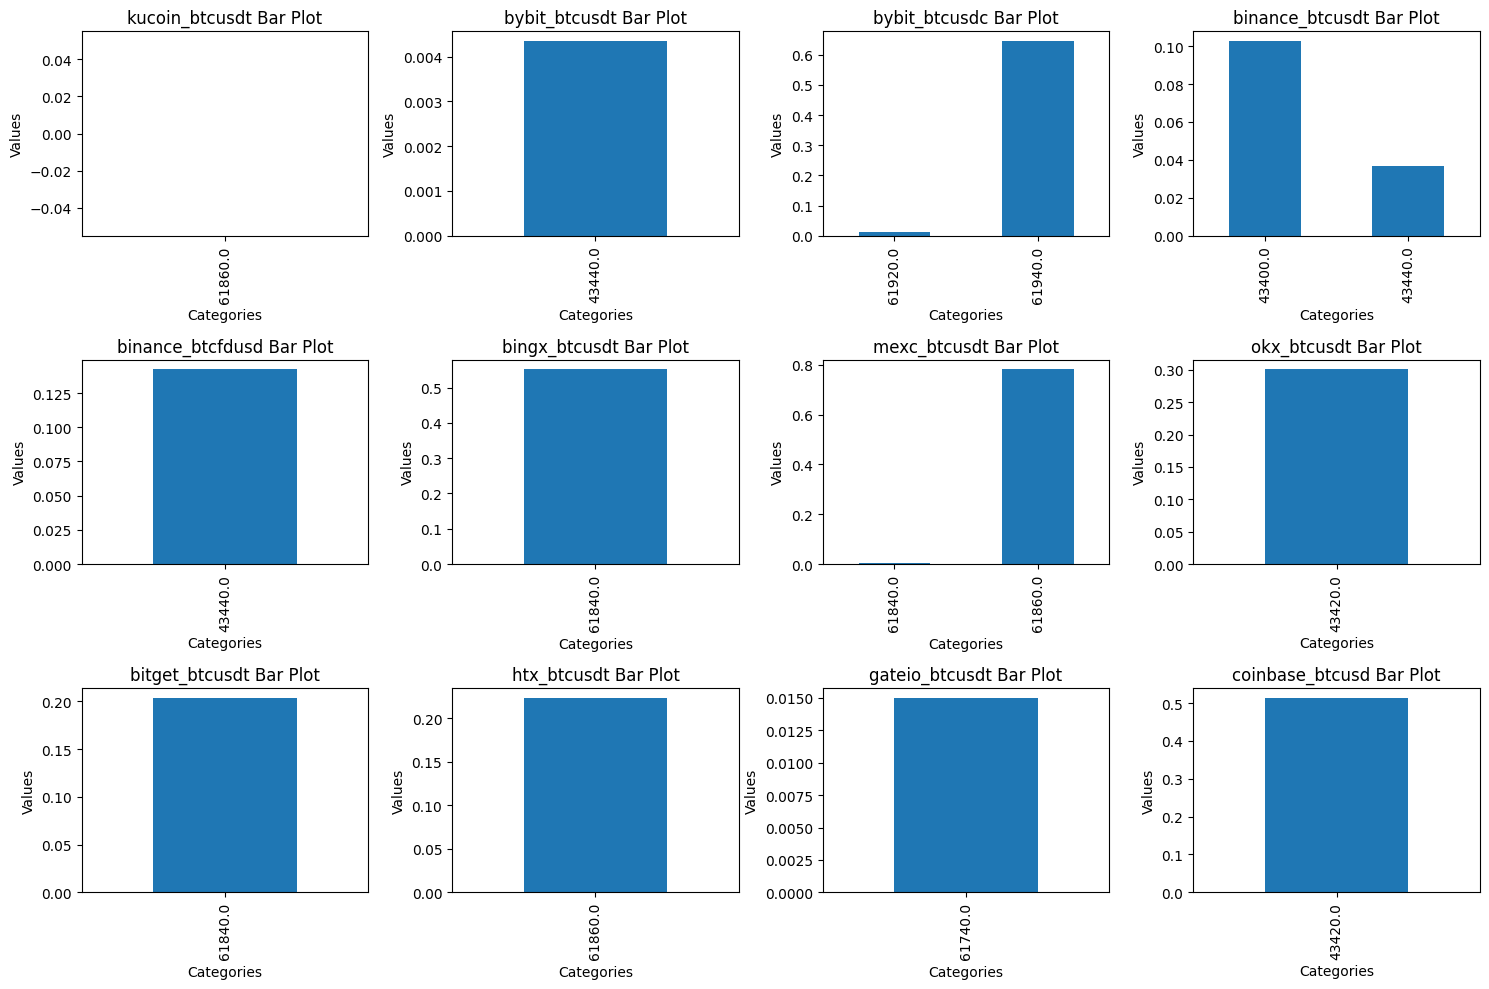

In [15]:
def plot_spot_trades():
    graphs = {}
    for exinstrument in list_spot_instruments:
        b = a.trades["spot"].axis[exinstrument].buys.iloc[:, 1:].sum()
        if b.sum() != 0:
            graphs[exinstrument] = b
        else:
            b = a.trades["spot"].axis[exinstrument].sells.iloc[:, 1:].sum()
            graphs[exinstrument] = b

    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))

    # Plot each Series separately
    for (series_name, series_values), ax in zip(graphs.items(), axes.flatten()):
        series_values.plot(kind='bar', ax=ax)
        ax.set_title(f'{series_name} Bar Plot')
        ax.set_xlabel('Categories')
        ax.set_ylabel('Values')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()
    plt.show()

plot_spot_trades()

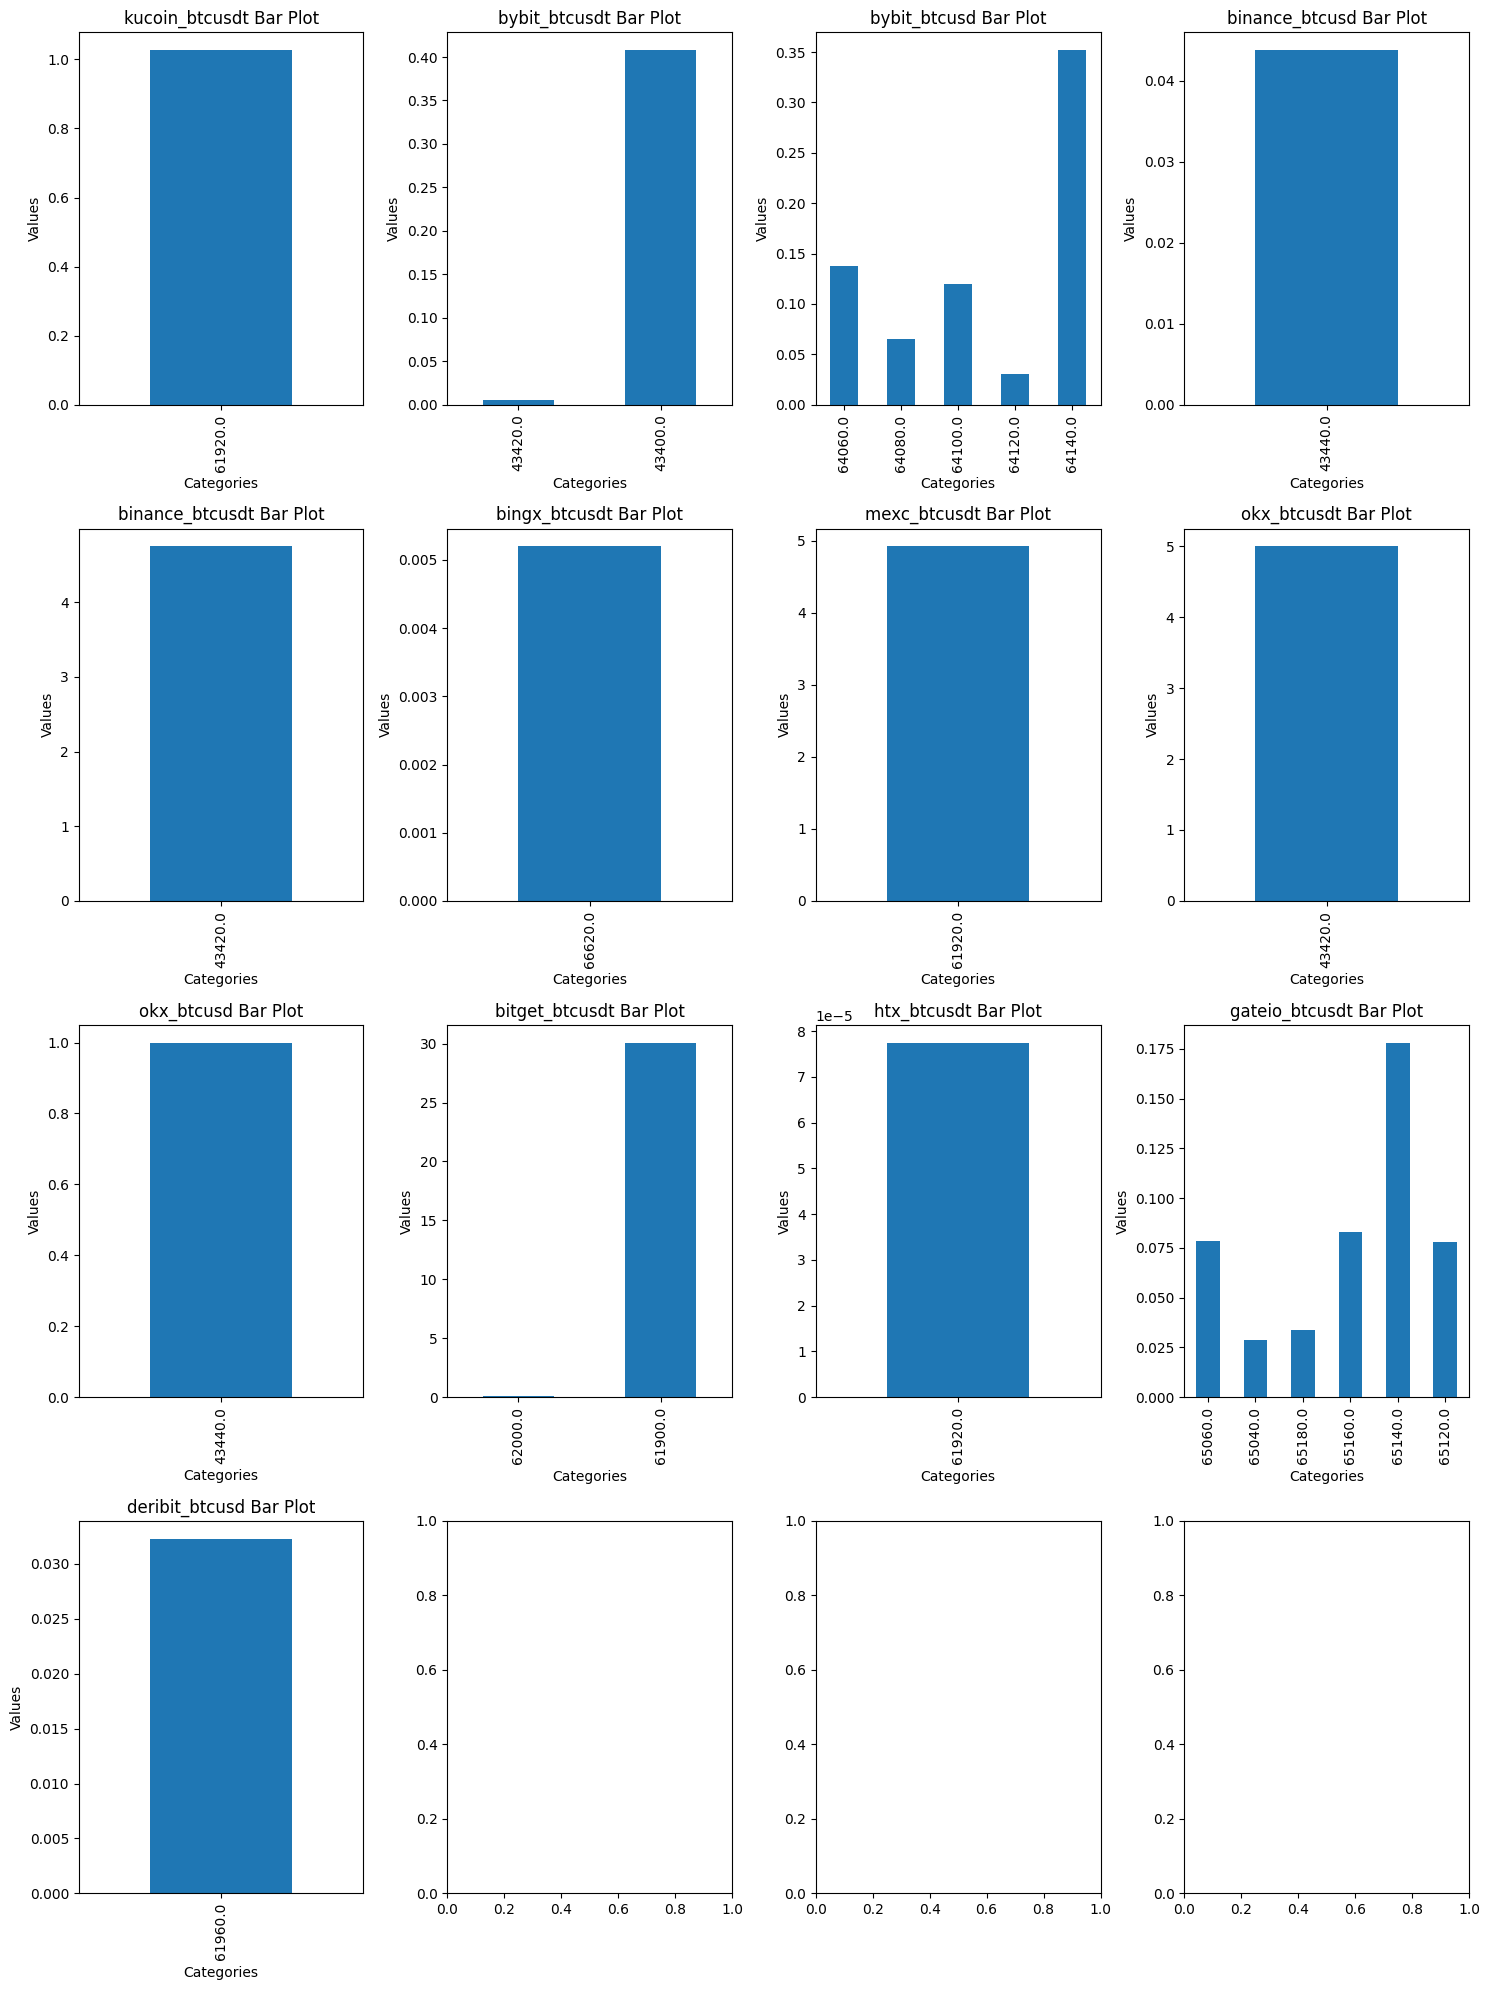

<Figure size 640x480 with 0 Axes>

In [16]:
def plot_perp_trades():
    graphs = {}
    for exinstrument in list_perp_instruments:
        b = a.trades["perpetual"].axis[exinstrument].buys.iloc[:, 1:].sum()
        if b.sum() != 0:
            graphs[exinstrument] = b
        else:
            b = a.trades["perpetual"].axis[exinstrument].sells.iloc[:, 1:].sum()
            graphs[exinstrument] = b

    # Calculate the number of rows and columns for the subplots
    num_plots = len(graphs)
    num_cols = min(4, num_plots)  # Set the maximum number of columns per row
    num_rows = -(-num_plots // num_cols)  # Calculate the number of rows

    # Customize figure size
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 5))

    # Plot each Series separately
    for (series_name, series_values), ax in zip(graphs.items(), axes.flatten()):
        series_values.plot(kind='bar', ax=ax)
        ax.set_title(f'{series_name} Bar Plot')
        ax.set_xlabel('Categories')
        ax.set_ylabel('Values')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    plt.show()

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()
    plt.show()
plot_perp_trades()

In [18]:
a.oifunding.axis["binance_btcusdt"].raw_data["oi"].max()

78736.736

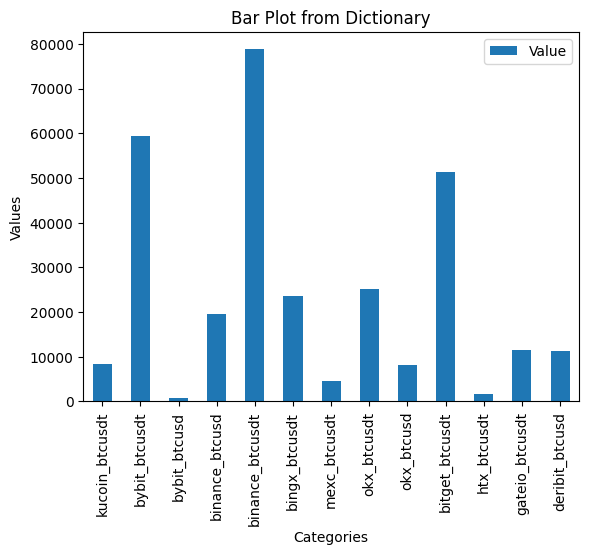

In [19]:
def plot_perp_oif():
    graphs = {}
    for exinstrument in list_perp_instruments:
        b = a.oifunding.axis[exinstrument].raw_data["oi"].max()
        graphs[exinstrument] = b

    df = pd.DataFrame(list(graphs.items()), columns=['Category', 'Value'])

    # Plot the DataFrame as a bar chart
    df.plot(x='Category', y='Value', kind='bar')

    # Customize the plot (optional)
    plt.title('Bar Plot from Dictionary')
    plt.xlabel('Categories')
    plt.ylabel('Values')
    plt.show()
    return graphs
a = plot_perp_oif()

In [11]:
a

{'kucoin_btcusdt': 8455.845,
 'bybit_btcusdt': 59341.426780758666,
 'bybit_btcusd': 823.2537389992622,
 'binance_btcusd': 19569.578177261377,
 'binance_btcusdt': 78736.736,
 'bingx_btcusdt': 23517.0473870415,
 'mexc_btcusdt': 4525.5142000000005,
 'okx_btcusdt': 5790.643258692203,
 'okx_btcusd': 3508443.0,
 'bitget_btcusdt': 51297.755,
 'htx_btcusdt': 1615.0036344968582,
 'gateio_btcusdt': 11595.506096278055,
 'deribit_btcusd': 11280.741817934719}